In [1]:
import numpy as np
import pandas as pd

In [2]:
turb_data=pd.read_csv('../../turb_data.csv')
turb_data

,x_coord,y_coord,ref_wind_speed,wind_speed,turb_num,num_tot_turb,ID,IDnum
0,0.000000,0.0,4.359392,6,0,3,3_turbine_155th_simulation,0
1,2633.103635,-226.0,4.387136,6,1,3,3_turbine_155th_simulation,0
2,57.854836,-545.0,4.358929,6,2,3,3_turbine_155th_simulation,0
3,0.000000,0.0,4.355684,6,0,3,3_turbine_141th_simulation,1
4,1935.499403,264.0,4.383674,6,1,3,3_turbine_141th_simulation,1
...,...,...,...,...,...,...,...,...
3835,294.588246,-52.0,18.847122,20,1,3,3_turbine_65th_simulation,1278
3836,1773.331277,-295.0,19.222500,20,2,3,3_turbine_65th_simulation,1278
3837,0.000000,0.0,19.118147,20,0,3,3_turbine_71th_simulation,1279
3838,3106.576695,-431.0,19.286488,20,1,3,3_turbine_71th_simulation,1279


In [3]:
dataset=turb_data.drop(['ID','turb_num'], axis=1)

In [4]:
import os
os.chdir("../..")
import descriptor.three_desc_model_nn as desc
from descriptor.cutoffs import Polynomial
import matplotlib.pyplot as plt
import GPy
from IPython.display import display
symbol="Siemens"
turb = [symbol]
numsims=dataset["IDnum"].iloc[-1]+1

In [5]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.25])
    plt.xlabel('Epoch')
    plt.ylabel('Error [ref_wind_speed]')
    plt.legend()
    plt.grid(True)

In [6]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        #layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [7]:
Gs = desc.make_symmetry_functions(turbines=symbol, type='G2',
                                    etas=np.linspace(1,10,5),
                                    offsets=np.linspace(1,5,5))
Gs += desc.make_symmetry_functions(turbines=symbol, type='G4',
                                     etas=np.linspace(1,10,5),
                                     gammas=np.linspace(0,10,5))
Gs += desc.make_symmetry_functions(turbines=symbol, type='G6',
                                     etas=np.linspace(1,10,5),
                                     gammas=np.linspace(0,10,5))

In [8]:
# Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":4.25387599, "offset": 1.0151402},
#                   {"type":"G4", "elements":"Siemens","eta":2.56450515, "gamma":8.04475192},
#                   {"type":"G6", "elements":"Siemens","eta":2.33043463, "gamma": 0.50753377}
#                  ]}

In [9]:
# Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":3.24310834, "offset": 1.9817547},
#                   {"type":"G4", "elements":"Siemens","eta":2.48579287, "gamma":12.39114317},
#                   {"type":"G6", "elements":"Siemens","eta":1.27537145, "gamma": 0.2110151}
#                  ]}

In [7]:
nl=desc.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
finpr=desc.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, len(Gs)))
dataset_rws=np.empty(shape=(0, 1))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    numturb=dataset["num_tot_turb"].iloc[count]
    position = np.empty((numturb,2))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    rws = np.empty((numturb,1))
    for k in range(numturb):
        position[k,0]=dataset["x_coord"].iloc[count]
        position[k,1]=dataset["y_coord"].iloc[count]
        ws[k,0]=dataset["wind_speed"].iloc[count]
        rws[k,0]=dataset["ref_wind_speed"].iloc[count]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_rws=np.append(dataset_rws,rws,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws, dataset_rws),axis=1)
dataset = pd.DataFrame(dataset)#, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed','Wind_Speed'])

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()
all_features = dataset.copy()

train_labels = train_features.iloc[:,-1]
test_labels = test_features.iloc[:,-1]
all_labels = all_features.iloc[:,-1]

NameError: name 'Gs' is not defined

In [28]:
dataset

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.0,4.359392
1,0.233323,0.233198,0.233073,0.232948,0.232823,0.776834,0.776664,0.776494,0.776324,0.776154,...,0.988164,0.992978,0.995835,0.987399,0.992525,0.995565,0.997369,0.998439,6.0,4.387136
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.0,4.358929
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.0,4.355684
4,0.488029,0.487901,0.487773,0.487645,0.487517,0.829232,0.829093,0.828954,0.828815,0.828676,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.0,4.383674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,0.173254,0.173048,0.172841,0.172634,0.172427,0.300872,0.300304,0.299735,0.299166,0.298597,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.0,18.847122
3836,0.882594,0.882564,0.882535,0.882505,0.882476,0.949428,0.949387,0.949345,0.949304,0.949263,...,0.999970,0.999970,0.999971,0.999981,0.999981,0.999981,0.999981,0.999981,20.0,19.222500
3837,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.0,19.118147
3838,0.355371,0.355241,0.355111,0.354982,0.354852,0.833610,0.833479,0.833348,0.833217,0.833086,...,0.996037,0.996237,0.996428,0.998897,0.998952,0.999005,0.999056,0.999104,20.0,19.286488


In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

2023-07-28 15:35:18.991386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 15:35:25.539694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 77)               155       
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                4992      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,772
Trainable params: 7,617
Non-trainable params: 155
____________________________________________________

In [13]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1000)

CPU times: user 1min 55s, sys: 8.08 s, total: 2min 3s
Wall time: 1min 31s


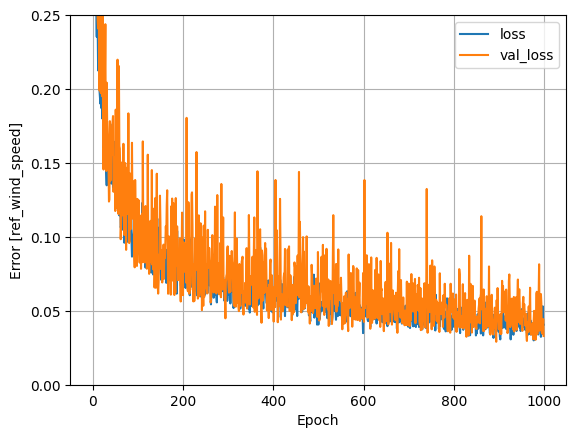

In [14]:
plot_loss(history)

120/120 [==============================] - 0s 802us/step


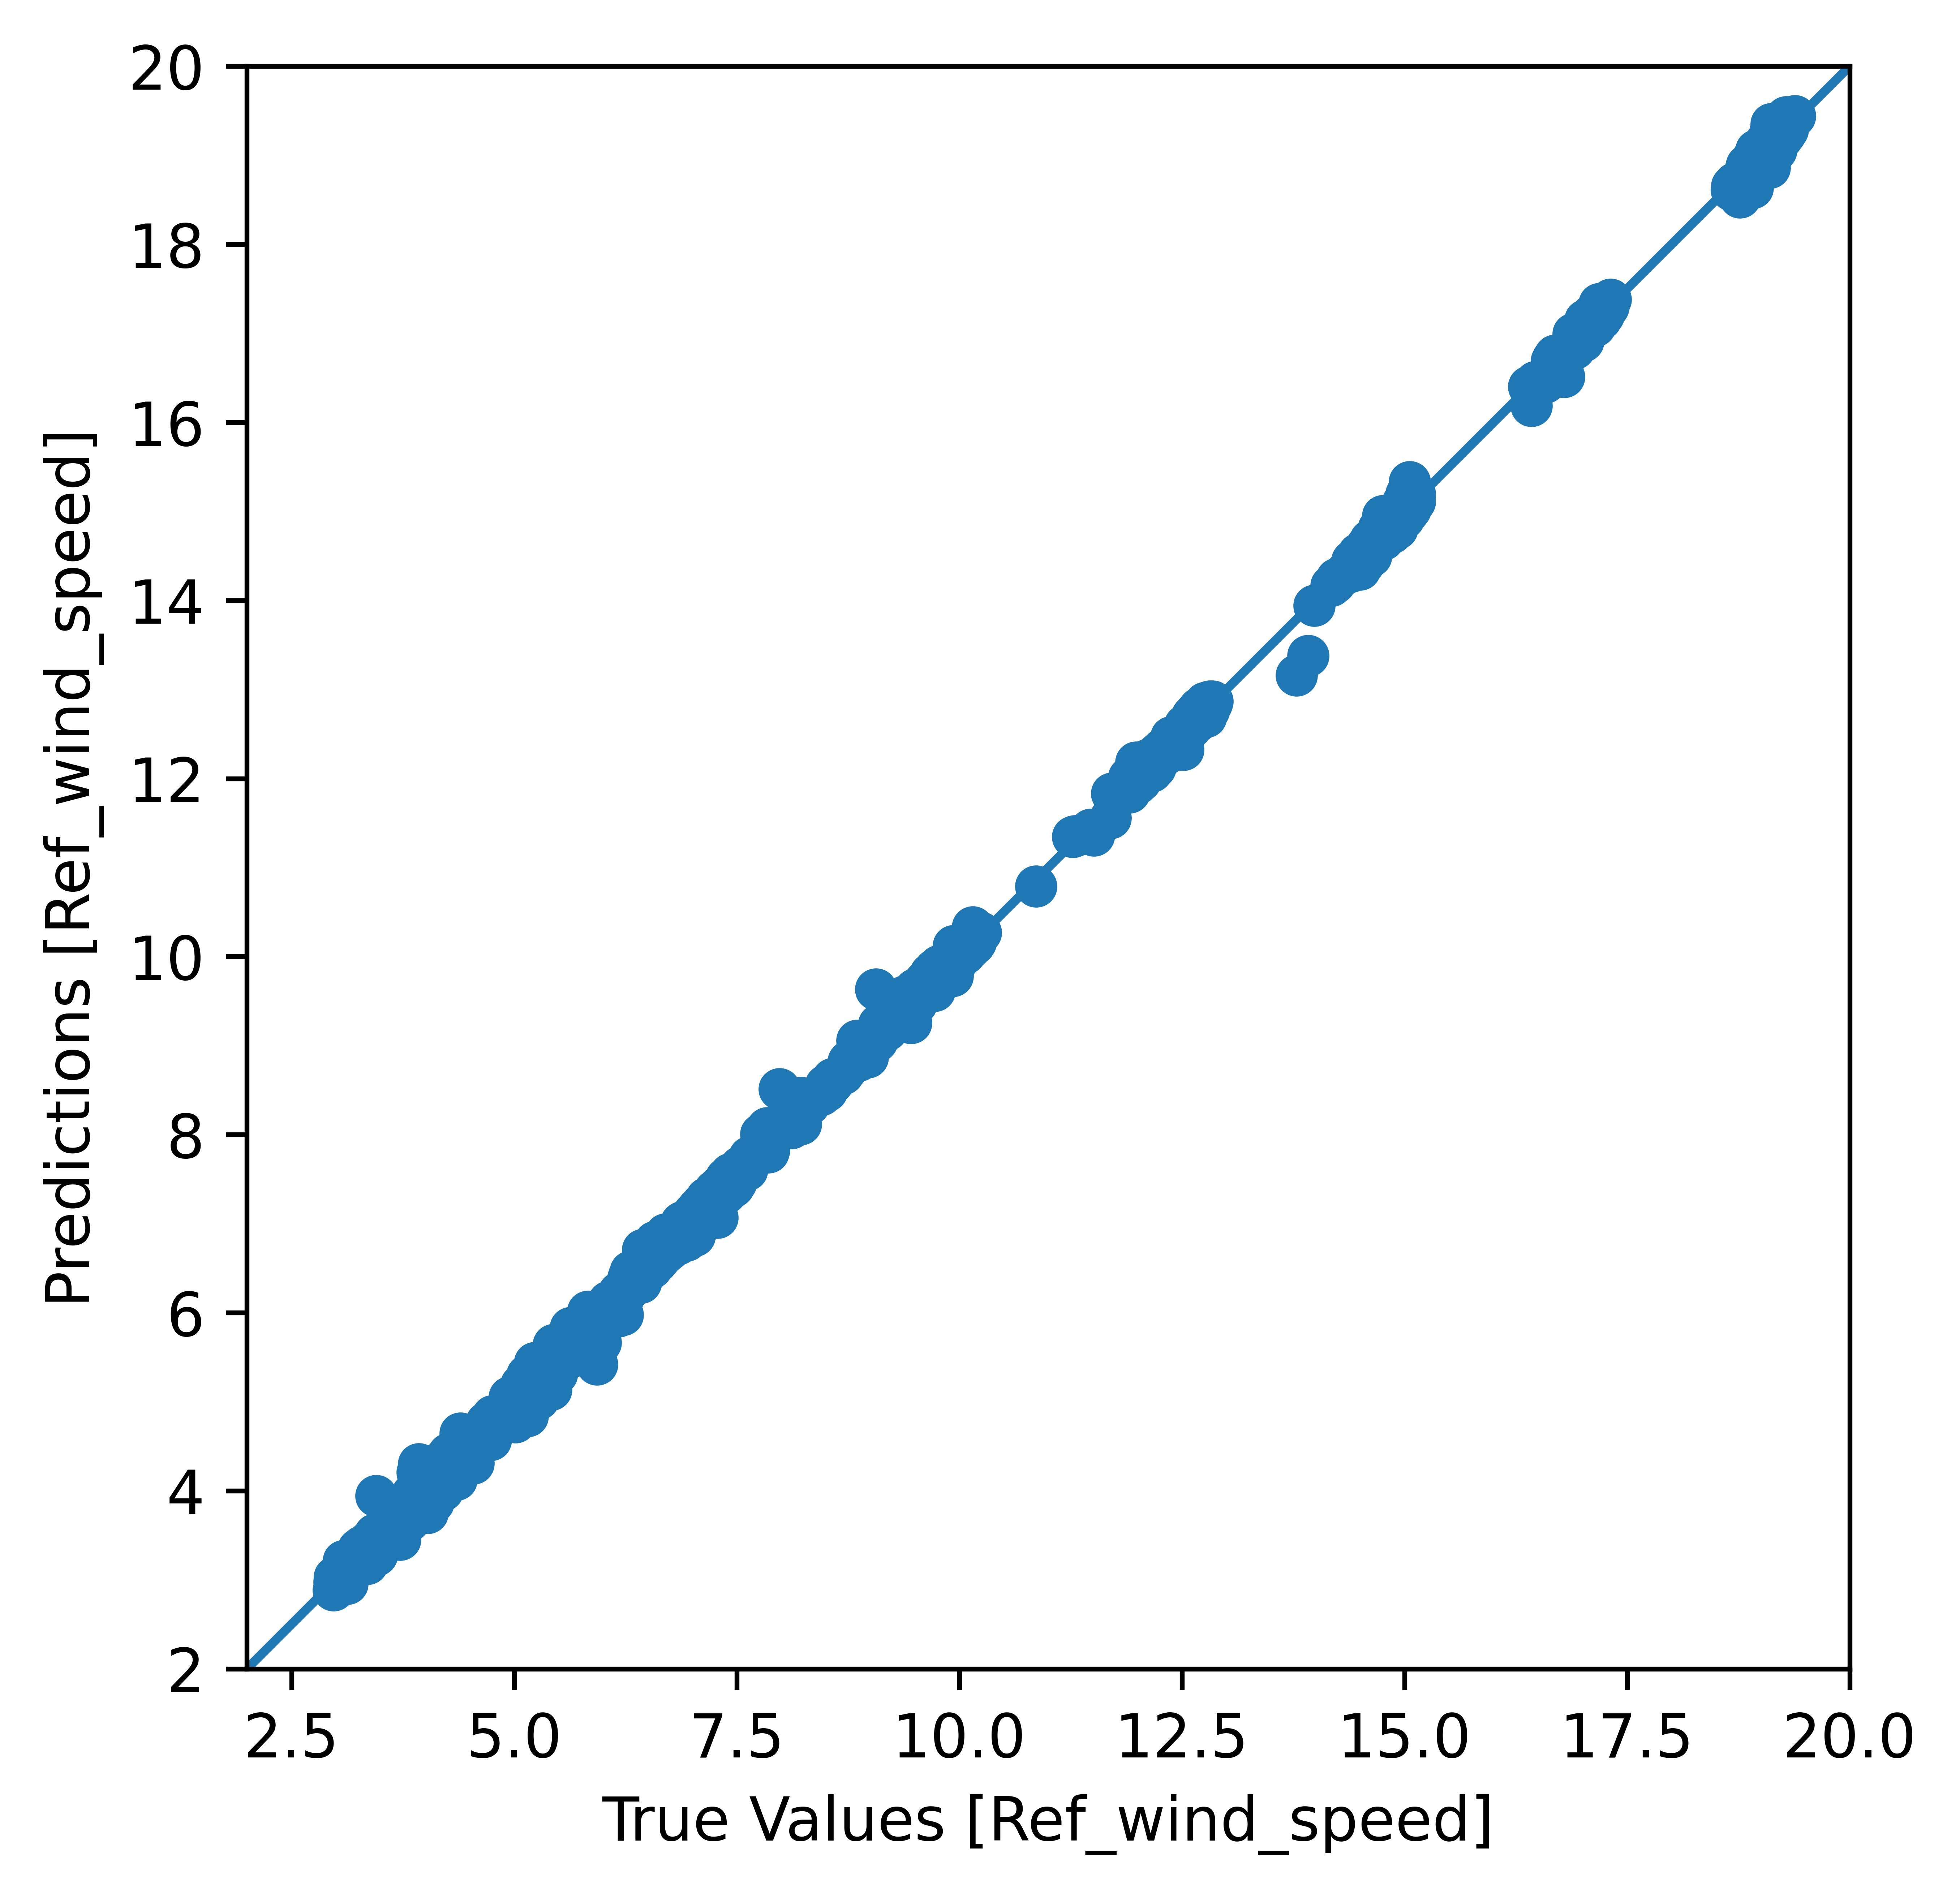

In [15]:
test_predictions = dnn_model.predict(test_features).flatten()
train_predictions = dnn_model.predict(train_features).flatten()
all_predictions = dnn_model.predict(all_features).flatten()
#test_predictions_0 = dnn_model.predict(test_features["Fingerprint(G2)"]==0).flatten()
#train_predictions_0 = dnn_model.predict(train_features["Fingerprint(G2)"]==0).flatten()
plt.figure(dpi=1200)
a = plt.axes(aspect='equal')
#plt.scatter(test_labels, test_predictions)#,c=test_features["Fingerprint(G2)"])
#plt.scatter(train_labels, train_predictions)#,c=train_features["Fingerprint(G2)"])
plt.scatter(all_labels, all_predictions)
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
#cbar=plt.colorbar()
#cbar.set_label('Fingerprint(G2)')
lims = [2, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

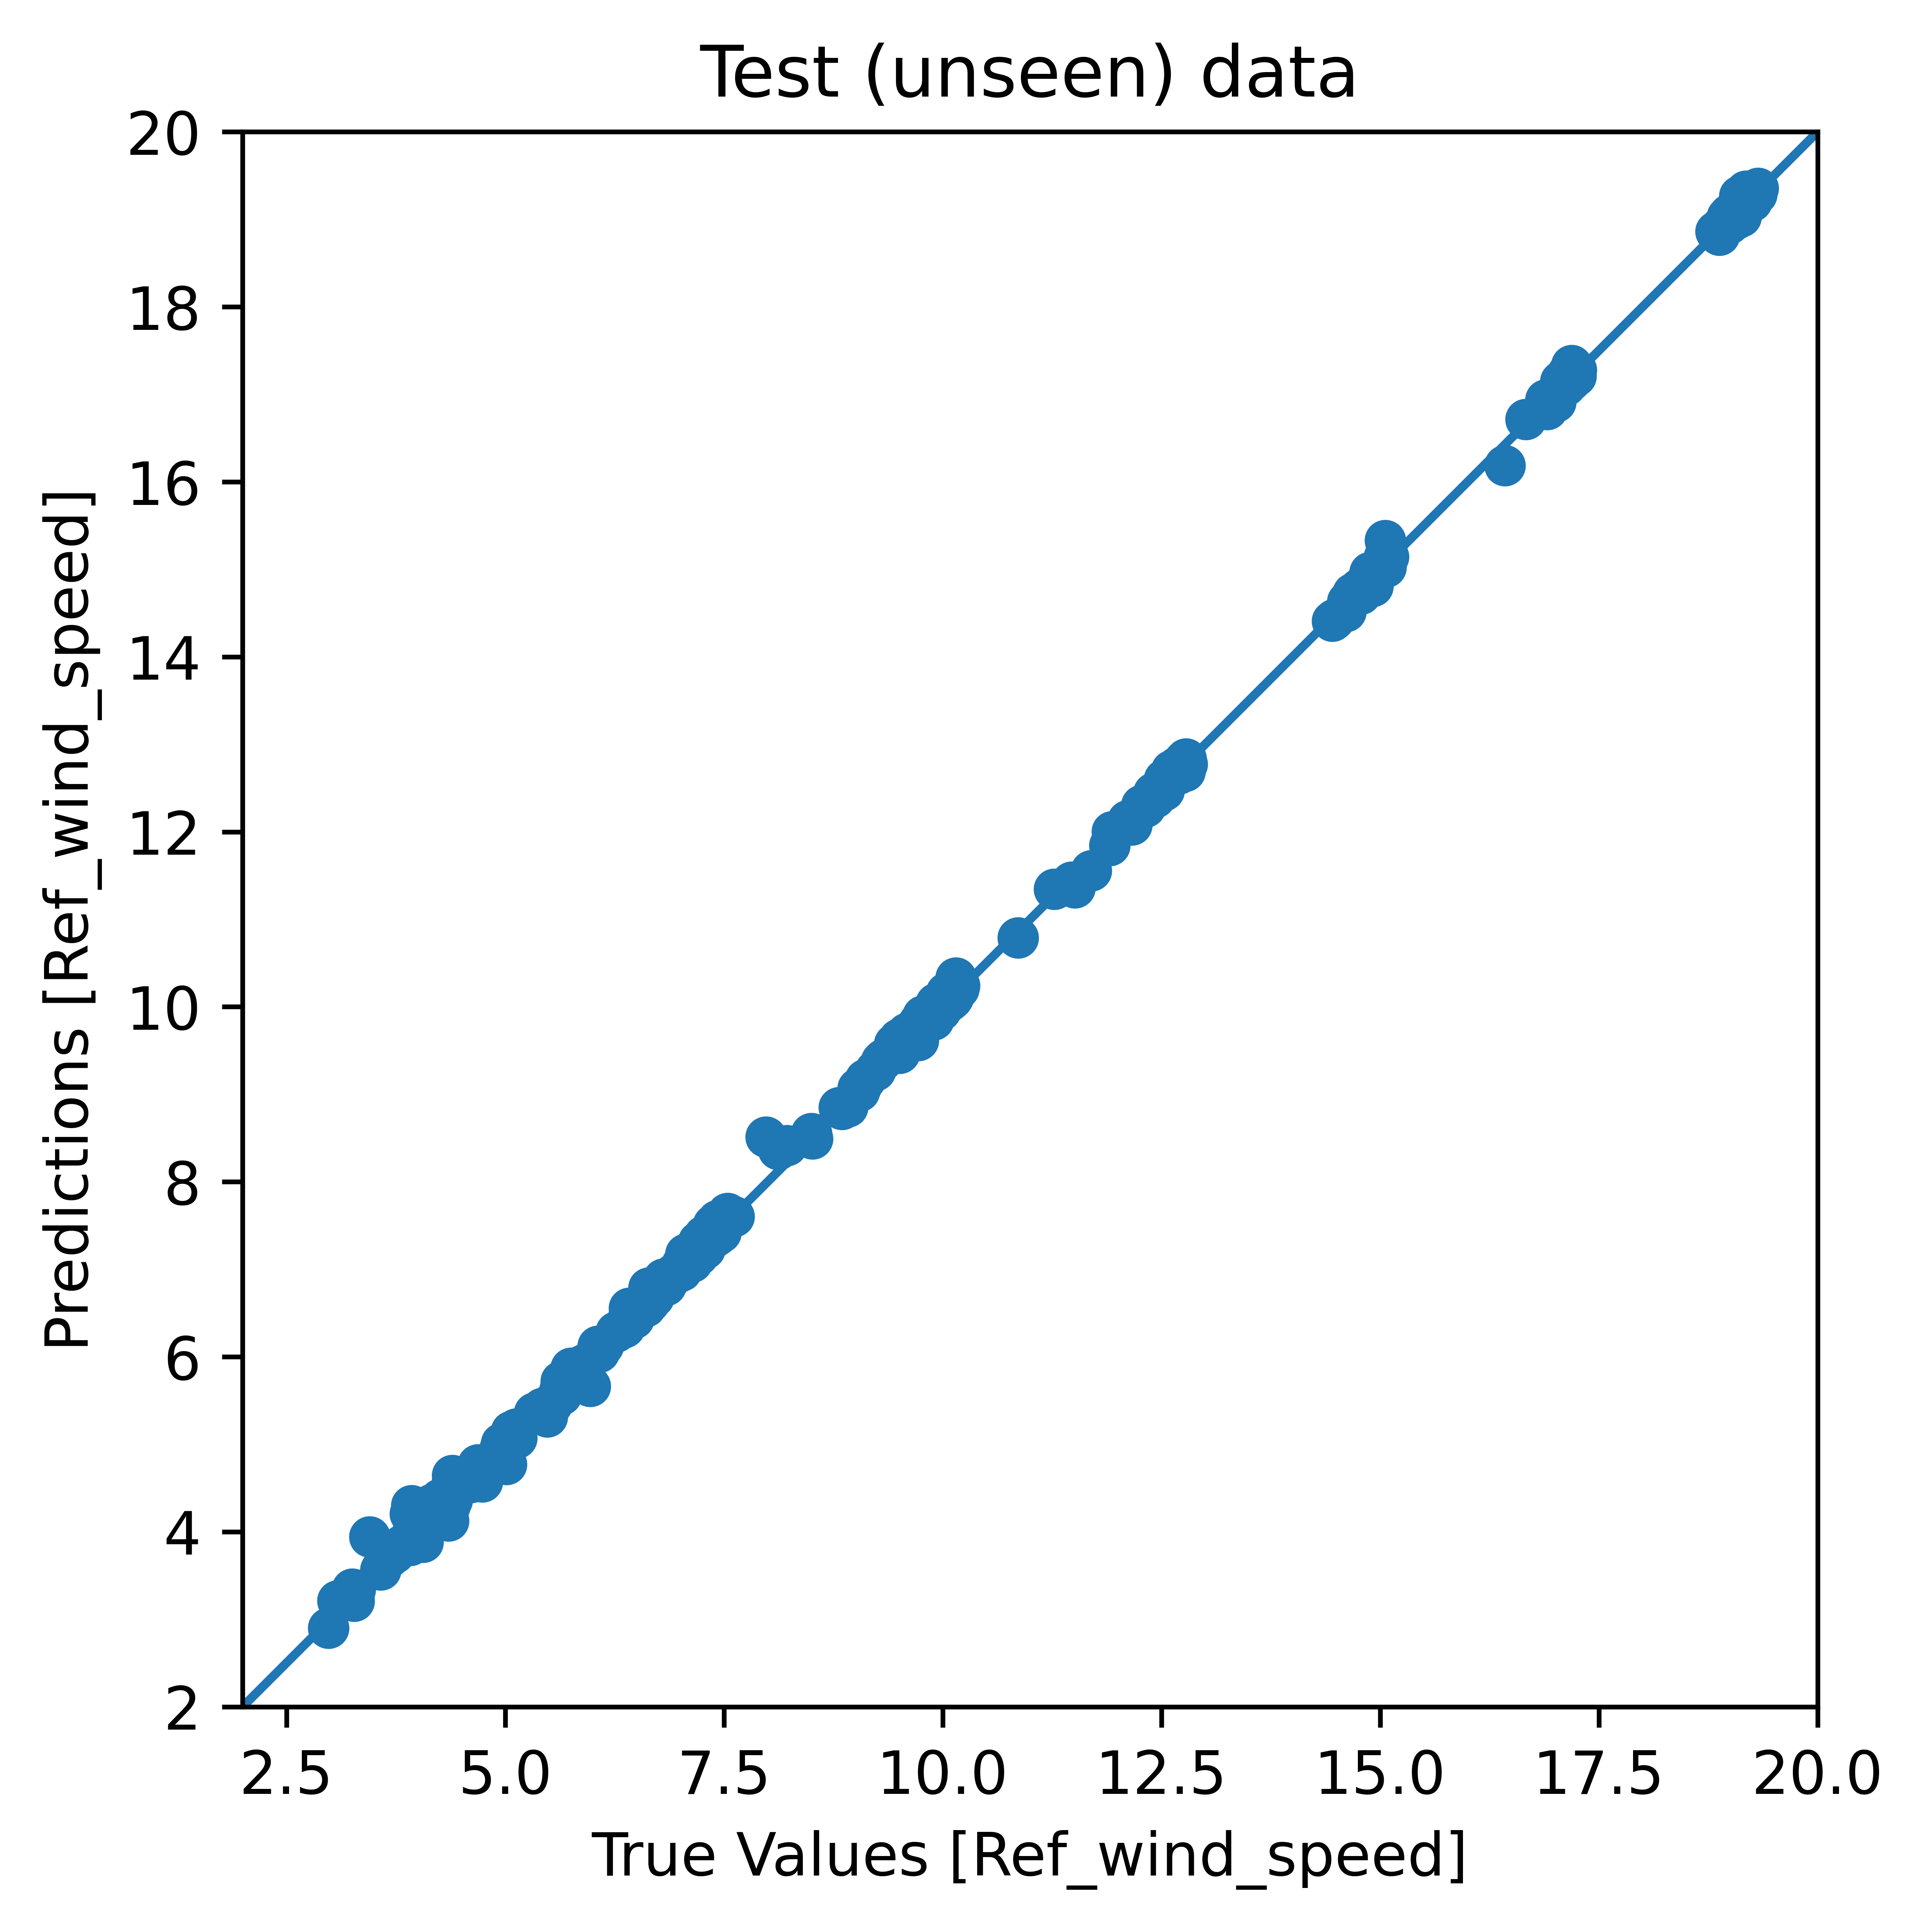

In [16]:
plt.figure(dpi=1200)
a = plt.axes(aspect='equal')
#plt.scatter(test_labels, test_predictions)#,c=test_features["Fingerprint(G2)"])
#plt.scatter(train_labels, train_predictions)#,c=train_features["Fingerprint(G2)"])
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
plt.title('Test (unseen) data')
#cbar=plt.colorbar()
#cbar.set_label('Fingerprint(G2)')
lims = [2, 20]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

120/120 [==============================] - 0s 704us/step


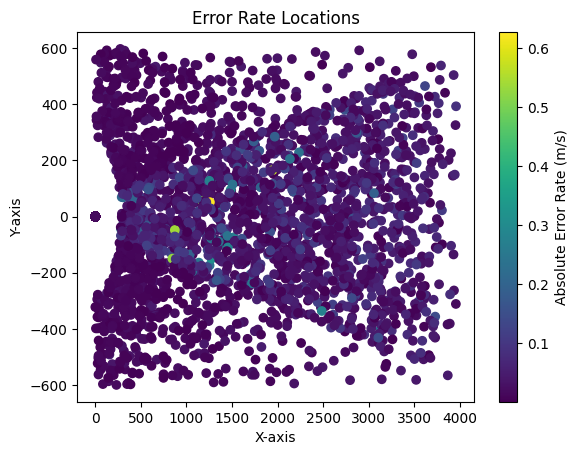

In [17]:
all_predictions = dnn_model.predict(all_features).flatten()
a = plt.axes
error_all=np.abs(all_predictions-all_labels)

plt.scatter(dataset_pos[:,0], dataset_pos[:,1],c=error_all)
#plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=train_labels)
#plt.scatter(train_labels, train_predictions)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Error Rate Locations')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

In [18]:
arg=np.argsort(error_all)
error_all[arg]

1077    9.532373e-07
2007    1.902726e-06
981     5.248485e-06
957     7.625471e-06
2947    1.053317e-05
            ...     
1390    5.085454e-01
2471    5.277243e-01
3061    5.391969e-01
2576    5.711031e-01
3001    6.275701e-01
Name: 76, Length: 3840, dtype: float64

120/120 [==============================] - 0s 757us/step


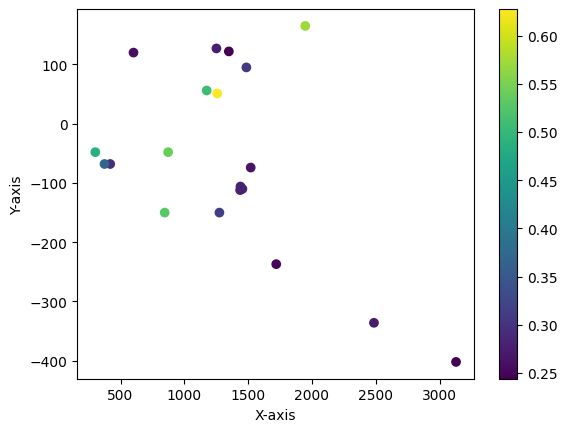

In [19]:
all_predictions = dnn_model.predict(all_features).flatten()
a = plt.axes
error_all=np.abs(all_predictions-all_labels)

plt.scatter(dataset_pos[arg[-20:],0], dataset_pos[arg[-20:],1],c=error_all[arg[-20:]])
#plt.scatter(train_features["Fingerprint(G2)"], train_features["Fingerprint(G4)"],c=train_labels)
#plt.scatter(train_labels, train_predictions)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()

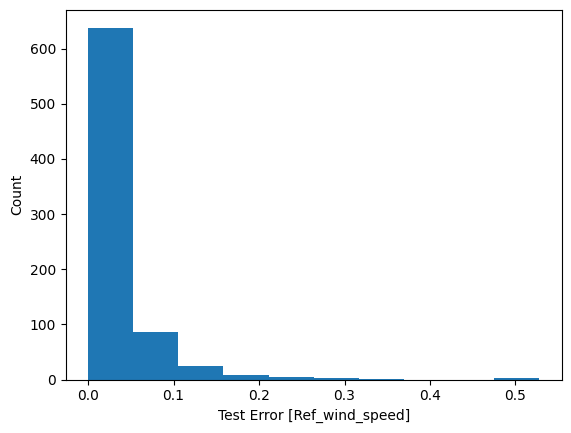

In [20]:
error_test = np.abs(test_predictions - test_labels)
plt.hist(error_test, bins=10)
plt.xlabel('Test Error [Ref_wind_speed]')
_ = plt.ylabel('Count')

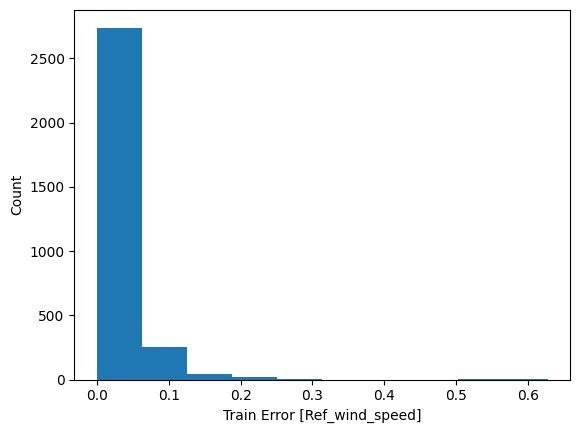

In [21]:
error_train = np.abs(train_predictions - train_labels)
plt.hist(error_train, bins=10)
plt.xlabel('Train Error [Ref_wind_speed]')
_ = plt.ylabel('Count')

In [22]:
print("Max test error:",np.max(error_test))
print("Mean test error:",np.mean(error_test))

Max test error: 0.5277242615722653
Mean test error: 0.032304814603668824


In [23]:
print("Max all error:",np.max(error_all))
print("Mean all error:",np.mean(error_all))

Max all error: 0.6275701356567378
Mean all error: 0.028865410534137406


In [24]:
print("Max train error:",np.max(error_train))
print("Mean train error:",np.mean(error_train))

Max train error: 0.6275701356567378
Mean train error: 0.028005559206313698


In [25]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


INFO:tensorflow:Assets written to: dnn_model/assets


In [26]:
print(min(error),max(error))

NameError: name 'error' is not defined

In [ ]:
import matplotlib.cm as cm
plt.scatter(dataset['Fingerprint(G4)'],dataset['Fingerprint(G2)'], c=dataset['Ref_Wind_Speed'], s=10, cmap=cm.bwr)
cbar= plt.colorbar()
plt.xlabel('Fingerprint(G4)')
plt.ylabel('Fingerprint(G2)')
plt.show()

In [ ]:
# dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
# import numpy
# from mayavi.mlab import *

# def test_points3d():


#     x = all_features["Fingerprint(G2)"]
#     y = all_features["Fingerprint(G4)"]
#     z = all_features["Fingerprint(G6)"]
#     s = error_all
#     colorbar(orientation='vertical')
#     xlabel('Fingerprint(G2)')
#     ylabel('Fingerprint(G4)')
#     zlabel('Fingerprint(G6)')
#     return points3d(x, y, z, s, colormap="blue-red", scale_factor=0.05)
# test_points3d()
# #colorbar(object=all_labels, title="Points in Mayavi")
# #view()
# show()